# ***Bias Mitigation in Automated Loan Eligibility Process***
**@authors: Chiara Angileri, Niccolò Marzi, Shola Oshodi** 



Project Description:

Based on a German credit risk dataset, the work undertaken aimed to identify any bias and discrimination in credit allocation and to identify potential mitigation strategies. The most well-known methods from the literature were used and their effectiveness in solving this specific problem was compared.

The dataset can be found in this link: https://www.kaggle.com/datasets/kabure/german-credit-data-with-risk

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as skm
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, confusion_matrix, balanced_accuracy_score
from sklearn.calibration import CalibratedClassifierCV

from scipy.stats import chi2_contingency
from scipy.stats import cumfreq


import fairlearn.metrics as flm
from fairlearn.metrics import MetricFrame
from fairlearn.reductions import GridSearch, DemographicParity



import warnings
warnings.filterwarnings("ignore")

random_seed = 1234

C:\Users\chiar\AppData\Local\Temp\ipykernel_15108\3650516951.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# 1. **Data collection**

In [2]:
# Import the dataset
df = pd.read_csv('loan_data_set2.csv')
df

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad
...,...,...,...,...,...,...,...,...,...,...,...
995,995,31,female,1,own,little,NaN,1736,12,furniture/equipment,good
996,996,40,male,3,own,little,little,3857,30,car,good
997,997,38,male,2,own,little,NaN,804,12,radio/TV,good
998,998,23,male,2,free,little,little,1845,45,radio/TV,bad


**Dataset Description:**
| Variable | Description | 
|------|------|
| Unamed:0 | Unique  ID | 
| Age | Age (int) | 
| Sex | female/male | 
| Job | 0 — unskilled and non-resident, 1 — unskilled and resident, 2 — skilled, 3 — highly skilled | 
| Housing | Free / Own / Rent | 
| Saving Account | little / moderate/ quite rich /  rich | 
| Checking account | little / moderate /  rich | 
| Credit Amount | Credit Amount  | 
| Duration | Duration of loan in months | 
| Purpose | Reason for the loan request | 
| Risk | good / bad | 

There are 1000 observations in this dataset.

## 1.1 **Exploratory Data Analysis (EDA)**

In [3]:
print(f'Number of rows: {df.shape[0]}')
print(f'Number of columns: {df.shape[1]}')

Number of rows: 1000
Number of columns: 11


In [4]:
# Show the data types for each column of the dataset
df.dtypes

Unnamed: 0           int64
Age                  int64
Sex                 object
Job                  int64
Housing             object
Saving accounts     object
Checking account    object
Credit amount        int64
Duration             int64
Purpose             object
Risk                object
dtype: object

In [5]:
# Summary of the dataset, info about index dtype, column dtypes, non-null values and memory usage
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
 10  Risk              1000 non-null   object
dtypes: int64(5), object(6)
memory usage: 86.1+ KB


In [6]:
def plot_column_distributions(data, palette='husl', rotation = 0):
    num_columns = data.shape[1]
    num_rows = (num_columns + 2) // 3  # Calculate the number of rows needed for the subplots grid
    
    fig, axes = plt.subplots(num_rows, 3, figsize=(18, 6 * num_rows))  # Create subplots grid
    axes = axes.flatten()  # Flatten the axes array for easy iteration

    for i, column in enumerate(data.columns):
        ax = axes[i]
        
        value_counts = data[column].value_counts(normalize=True)
        sns.barplot(x=value_counts.index, y=value_counts.values, palette=palette, ax=ax)
        ax.set_title(f'Distribution of {column}', fontsize=14, weight='bold')
        ax.set_ylabel('Proportion', fontsize=12)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation) 
        for p in ax.patches:
            height = p.get_height()
            ax.annotate(f'{height*100:.2f}%', (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                        textcoords='offset points')
        
        
    # Remove any empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

### 1.1.1. **Univariate analysis**

In the following section, we will delve deeper into the distribution of features.








***Target Variable***: We will first look at the target variable, i.e., Risk.

In [7]:
target_variable = 'Risk'
df[target_variable].value_counts(normalize=True)

Risk
good    0.7
bad     0.3
Name: proportion, dtype: float64

<Axes: title={'center': 'Distribution of Risk'}, xlabel='Risk', ylabel='Count'>

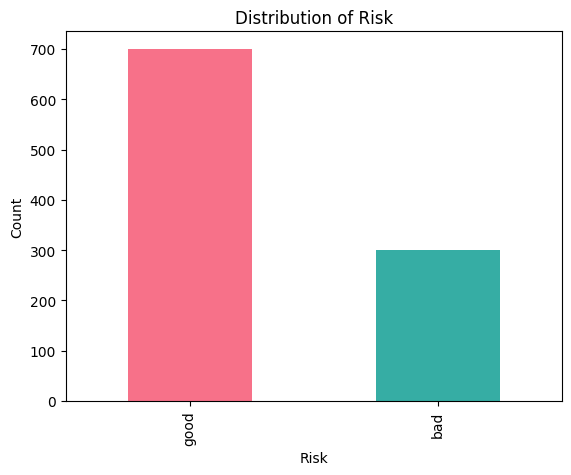

In [8]:
# Bar plot of the target variable
df[target_variable].value_counts().plot.bar(color=sns.color_palette('husl', 2), xlabel='Risk', ylabel='Count', title='Distribution of Risk')

- The graph reveals that instances of bad risk are relatively uncommon, comprising less than half of the instances classified as good risk.

***Categorical Variables***: let's analalyze categorical features (*Sex, Housing, Purpose, Job*)

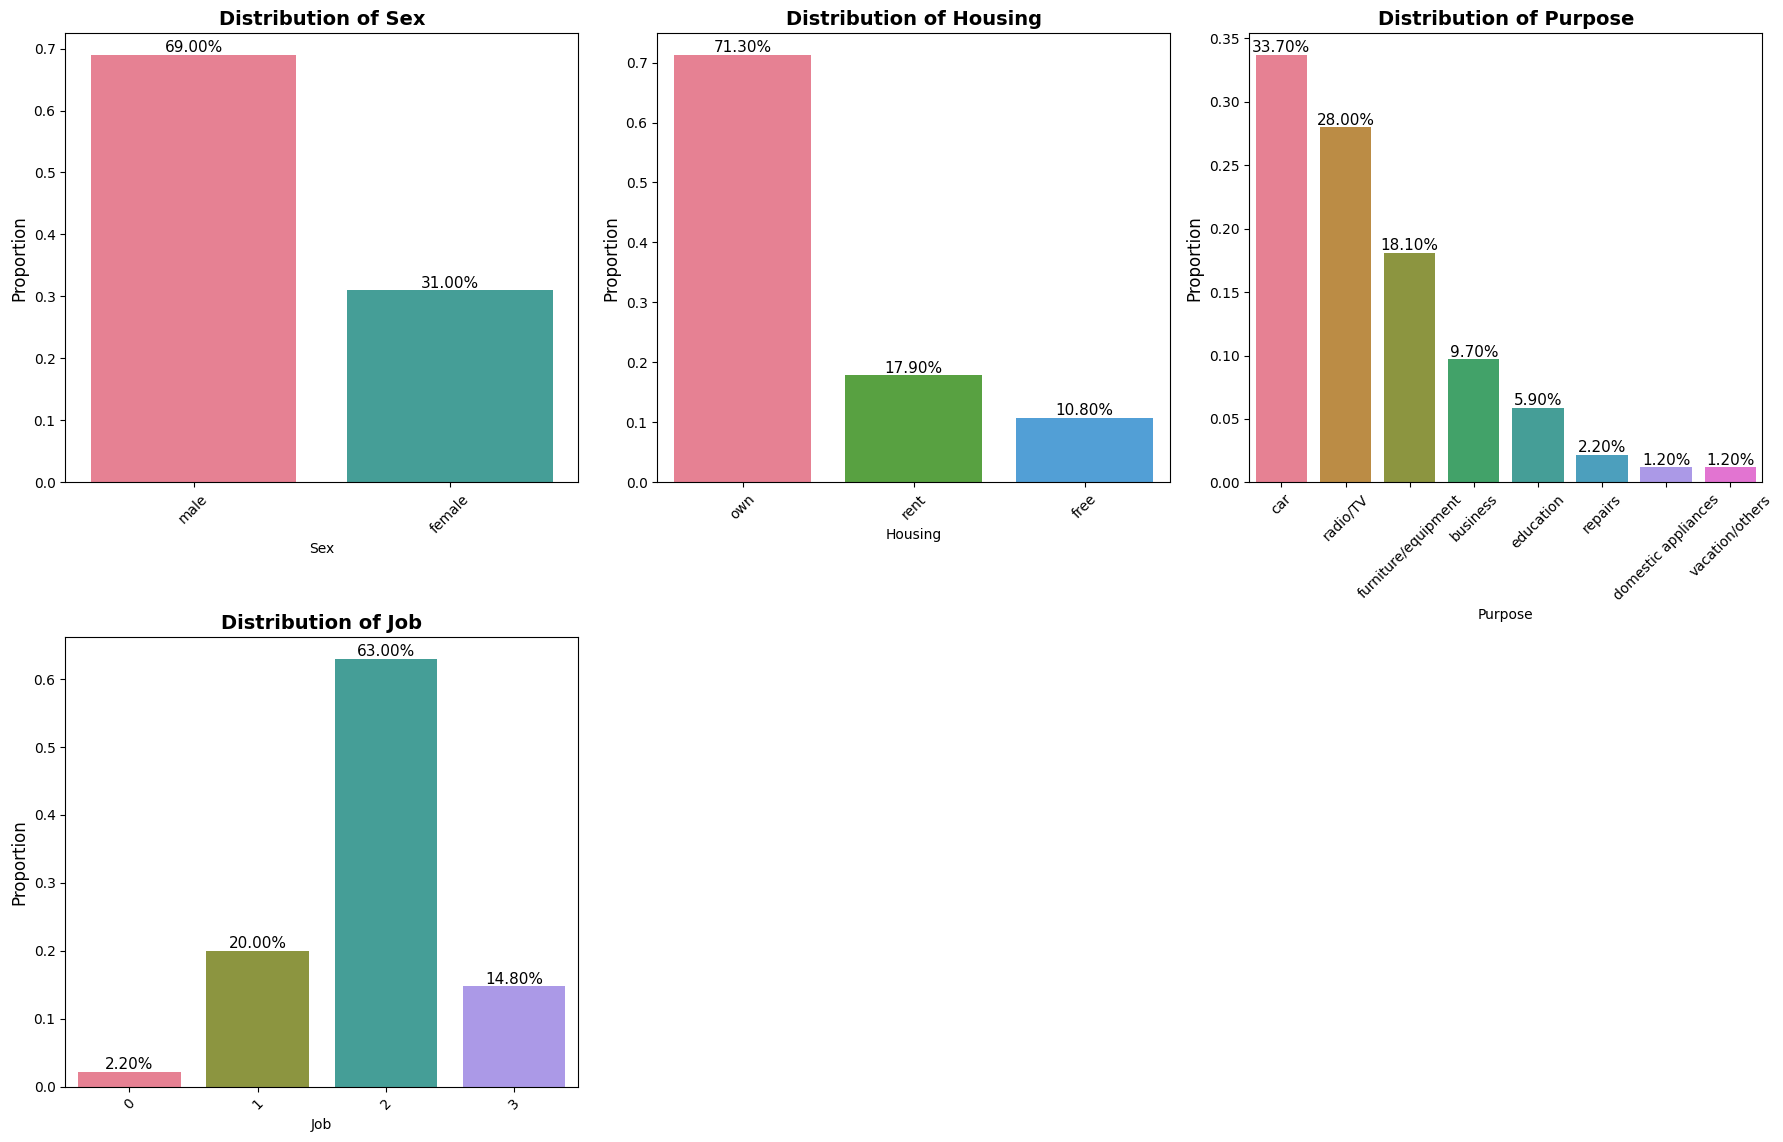

In [9]:
category_columns = ['Sex', 'Housing', 'Purpose', 'Job']
plot_column_distributions(df[category_columns], palette='husl', rotation=45)

- Observing the distributions of the variables is possible to notice an imbalance regarding the representation of men and women in the dataset, particularly with men accounting for 69.00% of cases.

- The majority of the subjects examined already own their homes and are seeking loans to purchase a car, a radio or a TV.

- Most of the people have been classified as unskilled residents, followed by skilled workers, highly skilled workers, and finally unskilled non-residents.

We were interested in understanding whether there were any differences in the purposes for which men and women applied for credit. To do so, we examined the data while differentiating by gender.

In [10]:
print("Percentage of purpose column by gender")
date_int = ["Purpose", 'Sex']
crosstab = pd.crosstab(df[date_int[0]], df[date_int[1]])
crosstab_percentage = crosstab.div(crosstab.sum(axis=0), axis=1) * 100
crosstab_percentage = crosstab_percentage.round(2)
styled_crosstab = crosstab_percentage.style.background_gradient(cmap="viridis")
styled_crosstab

Percentage of purpose column by gender


Sex,female,male
Purpose,,
business,6.130000,11.300000
car,30.320000,35.220000
domestic appliances,1.940000,0.870000
education,7.740000,5.070000
furniture/equipment,23.870000,15.510000
radio/TV,27.420000,28.260000
repairs,1.610000,2.460000
vacation/others,0.970000,1.300000


The distribution of purposes was found to be relatively balanced between the two genders, with the highest number of requests in both groups being for cars. However, slight differences were noticeable. For instance, the purchase of domestic appliances skewed towards women, while men were more prominent in categories such as business, repairs, and travel. Additionally, differences were observed in the categories of furniture and equipment.

***Ordinal Variables***: there are 2 ordinal features (*Saving accounts, Checking account*)

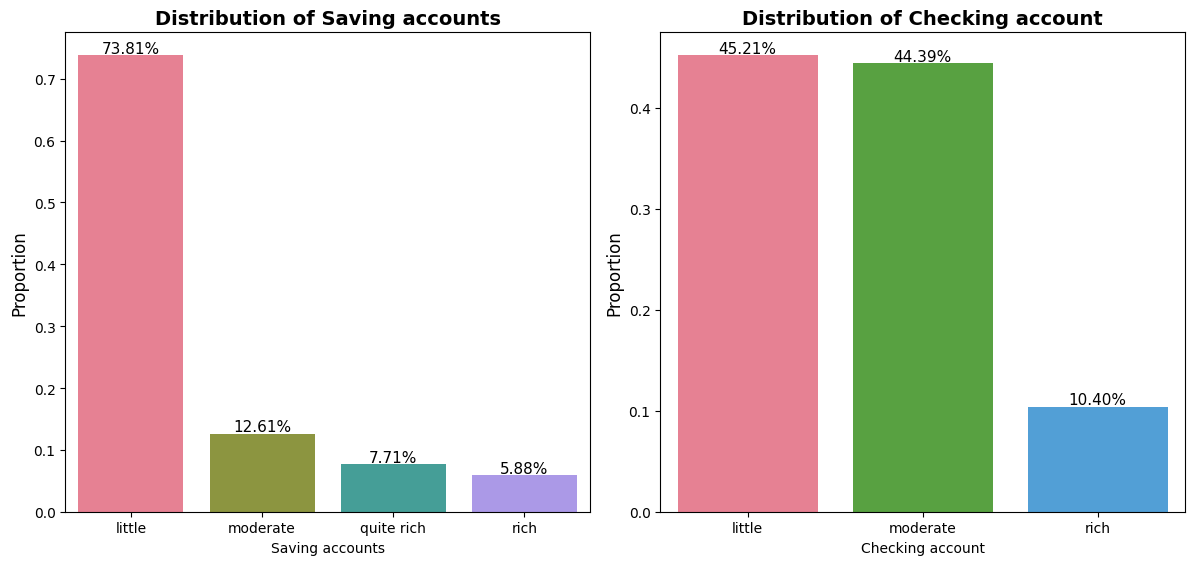

In [11]:
ordinal_columns = ['Saving accounts', 'Checking account']
plot_column_distributions(df[ordinal_columns])

- Observing the distribution, we can notice that the majority of the people who applied for a loan have a small amount in their savings account.
- Regarding their checking accounts, the dataset is mainly split between those with small and moderate balances, while a small portion has a high amount.

***Numerical Variables***: let's focus on numerical features (*Age, Credit amount, Duration)

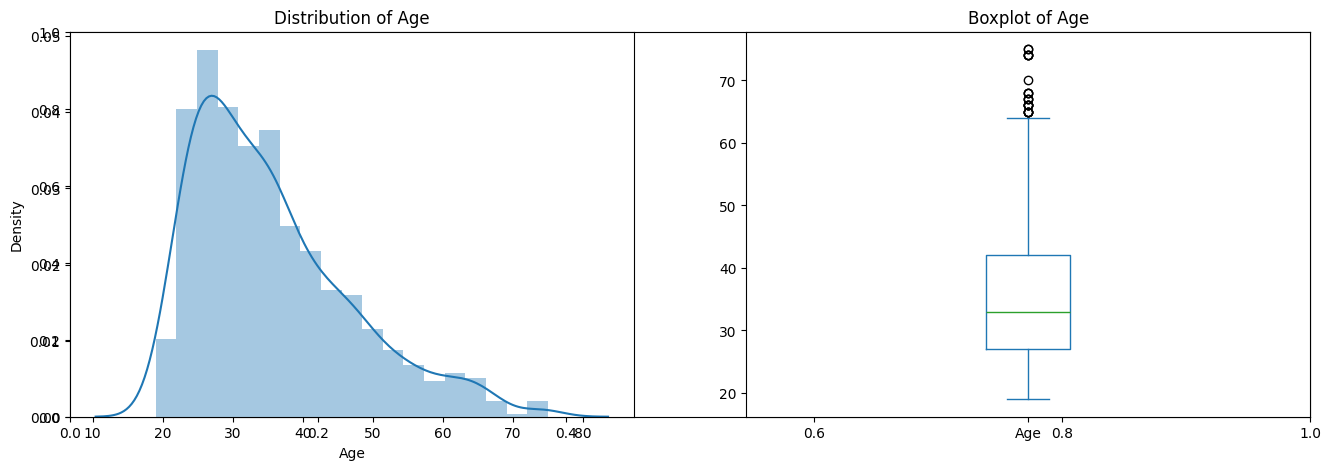

In [12]:
# LoanAmount
color_to_set = '#31356e'

plot_color = '#88dbff'

plt.subplots(figsize=(16,5))

plt.subplot(1, 2, 1)
sns.distplot(df['Age']);
plt.title('Distribution of Age')

plt.subplot(1, 2, 2)
df['Age'].plot.box(figsize=(16,5))
plt.title('Boxplot of Age')

plt.show()

The distribution is fairly normal, but there are some outliers.
The most common age range is **25-35**.

To handle ages more practically we decided to organize them in group divide as follows:
 - Young: Clients age ranges from (19 - 29).
 - Adults: Clients age ranges from (30-49)
 - Senior: Clients age ranges from (50-69)
 - Elder: Clients age is more than 69 years old

In [13]:
bins = [18, 29, 49, 69, float('inf')]
labels = ['Young', 'Adults', 'Senior', 'Elder']

df['Age group'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

<Axes: title={'center': 'Duration'}, xlabel='Duration'>

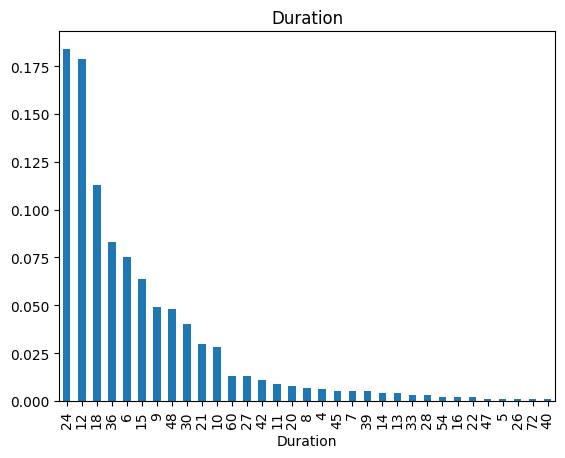

In [14]:
df['Duration'].value_counts(normalize=True).plot.bar(title= 'Duration')

The dataset is predominantly populated by short-term credit requests.

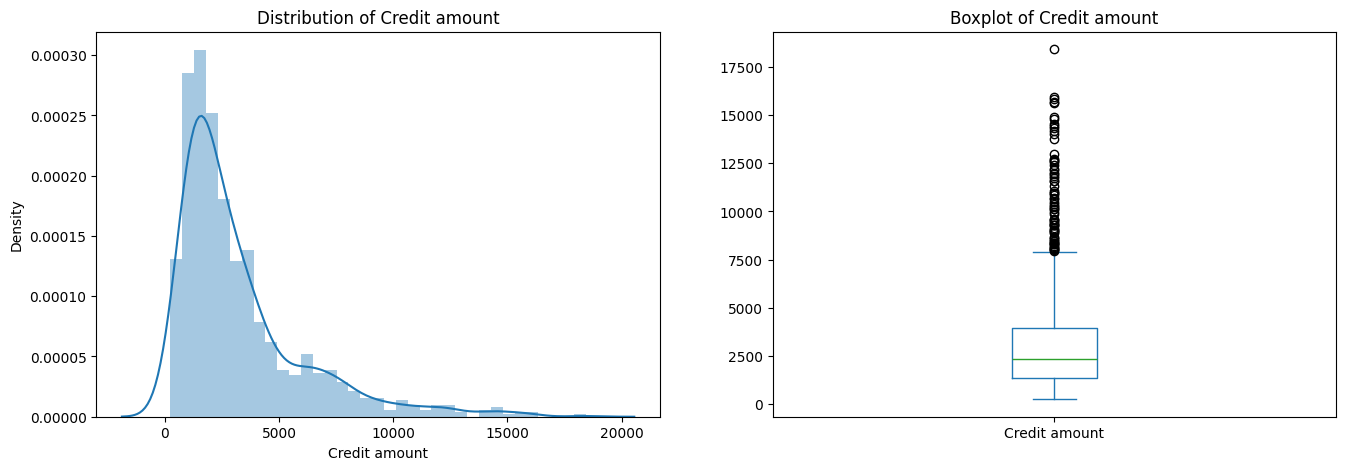

In [15]:
# Credit amount
plt.figure(figsize=(16,5))

plt.subplot(1, 2, 1)
sns.distplot(df['Credit amount']);
plt.title('Distribution of Credit amount')

plt.subplot(1, 2, 2)
df['Credit amount'].plot.box(figsize=(16,5))
plt.title('Boxplot of Credit amount')

plt.show()

In [16]:
df[['Age', 'Credit amount', 'Duration']].describe()

,Age,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000
mean,35.546000,3271.258000,20.903000
std,11.375469,2822.736876,12.058814
min,19.000000,250.000000,4.000000
25%,27.000000,1365.500000,12.000000
50%,33.000000,2319.500000,18.000000
75%,42.000000,3972.250000,24.000000
max,75.000000,18424.000000,72.000000


To summarize:

- The average age is approximately 35 years, ranging from 19 as the youngest to 72 as the oldest.
- The credit amount exhibits high variation but is primarily around 3000 euros.
- Most requests are for longer durations, typically spanning a couple of years, although it's possible to request loans for very short periods, such as 4 months.

### 1.1.2 **Bivariate Analysis**

We can perform Chi-square test to verify the independence of a categorical variable wrt the target variable.

**Chi-square test**: statistical method used to determine if there is a significant association between categorical variables. It's widely used in hypothesis testing. 

- *Null Hypothesis (H0)*: There is no association between the categorical variables. In other words, the observed frequencies in each category are consistent with the expected frequencies.
- *Alternative Hypothesis (H1)*: There is an association between the categorical variables. The observed frequencies differ significantly from the expected frequencies.

***Decision Criteria***
- *Reject the Null Hypothesis (H0)*: If the p-value is less than the chosen significance level (e.g., 0.05), it indicates that there is a significant association between the variables, and H0 is rejected in favor of H1.
- *Fail to Reject the Null Hypothesis (H0)*: If the p-value is greater than or equal to the significance level, it indicates that there is not enough evidence to suggest a significant association between the variables, and H0 is not rejected.

In [17]:
def plot_bivariate_relationship(data, x, y, palette='husl'):
    plt.figure(figsize=(6, 4))
    ax = sns.countplot(x=x, hue=y, data=data, palette=palette)
    for p in ax.patches:
        height = p.get_height()
        if height != 0:
            ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center', color='black', xytext=(0, 5),
                    textcoords='offset points')
    plt.show()

def chi_square_test(data, x, y, alpha = 0.05):
    contingency_table = pd.crosstab(data[x], data[y])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f'Chi-square test statistic: {chi2}')
    print(f'p-value: {p}')
    print(f'Degrees of freedom: {dof}')
    if p <= alpha:
        print(f'The two variables {x} and {y} are dependent (reject H0).')
    else:
        print(f'The two variables {x} and {y} are independent (fail to reject H0).')

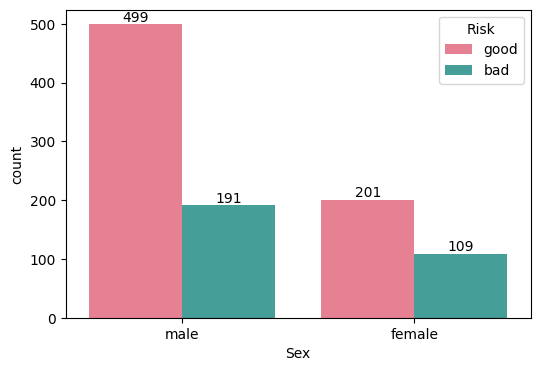

Chi-square test statistic: 5.348516218081436
p-value: 0.020739913068713305
Degrees of freedom: 1
The two variables Sex and Risk are dependent (reject H0).


In [74]:
plot_bivariate_relationship(df, 'Sex', 'Risk')
chi_square_test(df, 'Sex', 'Risk')

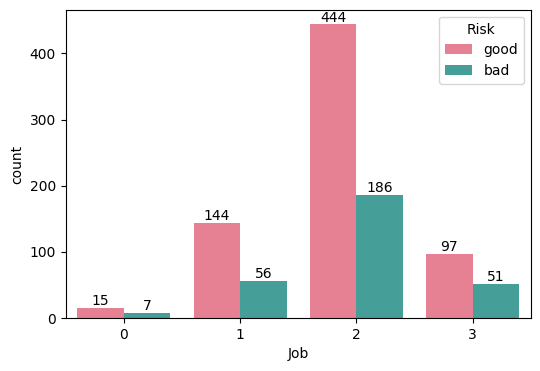

Chi-square test statistic: 1.8851560280131707
p-value: 0.5965815918843433
Degrees of freedom: 3
The two variables Job and Risk are independent (fail to reject H0).


In [75]:
plot_bivariate_relationship(df, 'Job', 'Risk')
chi_square_test(df, 'Job', 'Risk')

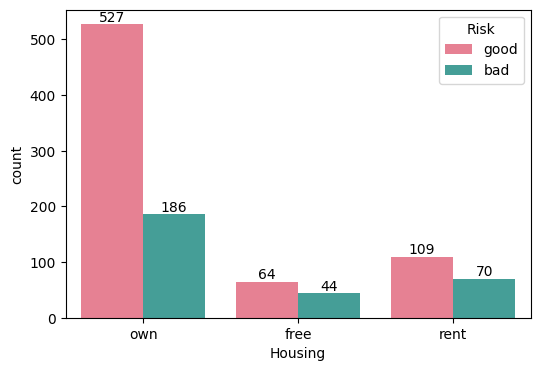

Chi-square test statistic: 18.19984158256362
p-value: 0.00011167465374597686
Degrees of freedom: 2
The two variables Housing and Risk are dependent (reject H0).


In [76]:
plot_bivariate_relationship(df, 'Housing', 'Risk')
chi_square_test(df, 'Housing', 'Risk')

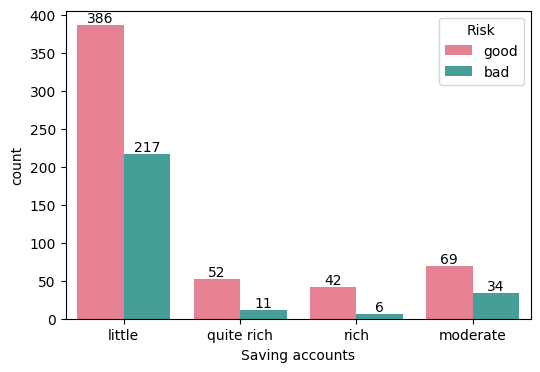

Chi-square test statistic: 18.479089902588285
p-value: 0.00035029499291971256
Degrees of freedom: 3
The two variables Saving accounts and Risk are dependent (reject H0).


In [77]:
plot_bivariate_relationship(df, 'Saving accounts', 'Risk')
chi_square_test(df, 'Saving accounts', 'Risk')

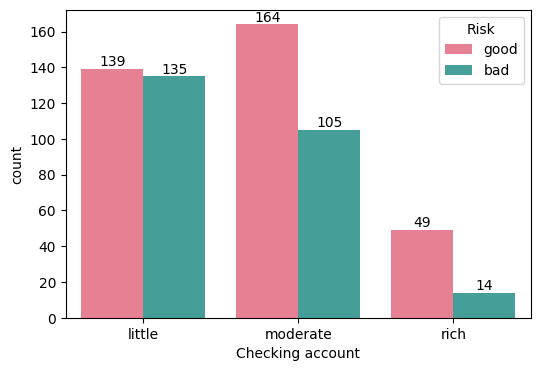

Chi-square test statistic: 17.04082801454835
p-value: 0.00019935687308106684
Degrees of freedom: 2
The two variables Checking account and Risk are dependent (reject H0).


In [78]:
plot_bivariate_relationship(df, 'Checking account', 'Risk')
chi_square_test(df, 'Checking account', 'Risk')

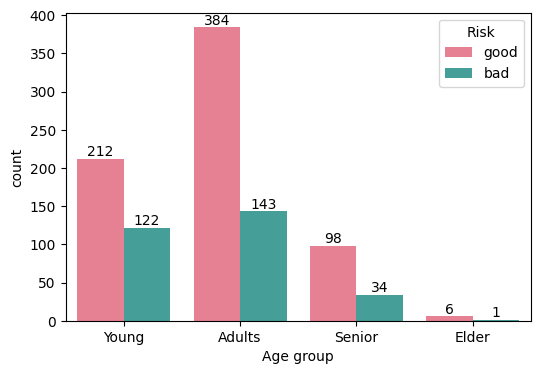

Chi-square test statistic: 10.790303325807
p-value: 0.012915546499848517
Degrees of freedom: 3
The two variables Age group and Risk are dependent (reject H0).


In [79]:
plot_bivariate_relationship(df, 'Age group', 'Risk')
chi_square_test(df, 'Age group', 'Risk')

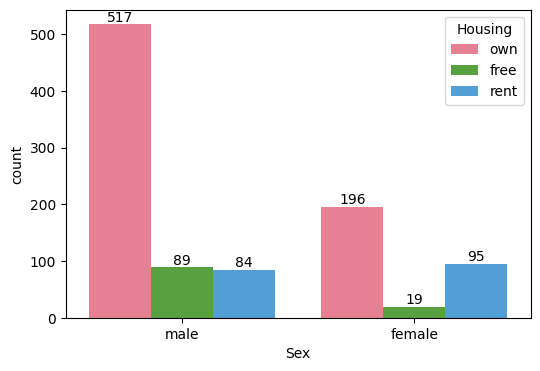

Chi-square test statistic: 53.95497847218782
p-value: 1.922318250514252e-12
Degrees of freedom: 2
The two variables Sex and Housing are dependent (reject H0).


In [19]:
plot_bivariate_relationship(df, 'Sex', 'Housing')
chi_square_test(df, 'Sex', 'Housing')

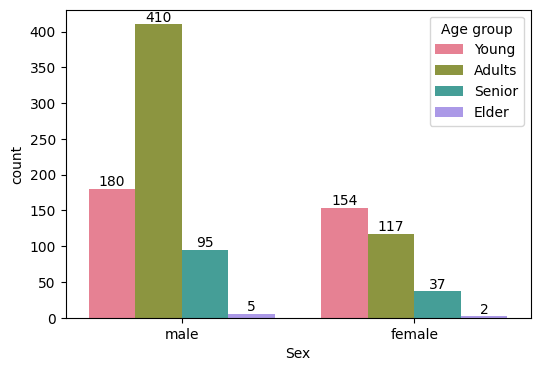

Chi-square test statistic: 55.277984034146726
p-value: 5.989742054945639e-12
Degrees of freedom: 3
The two variables Sex and Age group are dependent (reject H0).


In [23]:
plot_bivariate_relationship(df, 'Sex', 'Age group')
chi_square_test(df, 'Sex', 'Age group')


- **Risk vs Gender**: The proportion of males identified as good risks is higher, indicating that the two variables are **statistically dependent**.
- **Risk vs Job**: The risk classification proportion remains similar across all job categories, suggesting that the two variables are **statistically independent**.
- **Risk vs Housing**: Not owning a house increases the chances of being classified as a bad risk payer, indicating that the two variables are **statistically dependent**.
- **Age Group vs Risk**:  Young and Elederly groups had the highest ratio of high risk loans, so the two variable are **statistically dependent**
- Both **Checking Account** and **Saving Accounts** are **statistically dependent** on risk classification, as intuitively expected.

## 1.2 **Column Manipulation**

We can drop some columns from the dataset:
- We decide to drop Unamed:0 since is a progressive index already present in the table.
- Drop Age having introduced the feature Age Group

In [80]:
# Drop irrelevant columns
df.drop(columns=['Unnamed: 0', 'Age'], inplace=True)

In [81]:
# replacing Male and Female in Gender variable with 1 and 0 respectively
df['Sex'].replace({'male': 1, 'female': 0}, inplace=True)

In [82]:
# replacing bad and good risk variable with 1 and 0 respectively
df['Risk'].replace({'bad': 0, 'good': 1}, inplace=True)

## 1.3 Dataset Split

In [83]:
for col_name in category_columns:
    df[col_name] = df[col_name].astype("category")

Y, A = df.loc[:, "Risk"], df.loc[:, "Sex"]
X = pd.get_dummies(df.drop(columns=["Risk", "Sex"])) # we remove both the target variable and the sensitive attribute

In [84]:
A_str = A.map({1: "male", 0: "female"})
A_str.value_counts(normalize=True)

Sex
male      0.69
female    0.31
Name: proportion, dtype: float64

In [85]:
Y.value_counts(normalize=True)

Risk
1    0.7
0    0.3
Name: proportion, dtype: float64

In [86]:
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(X, Y, A, test_size=0.35, random_state=random_seed, stratify=Y)

print('Training set shape:', X_train.shape)
print('Test set shape:', X_test.shape)

Training set shape: (650, 28)
Test set shape: (350, 28)


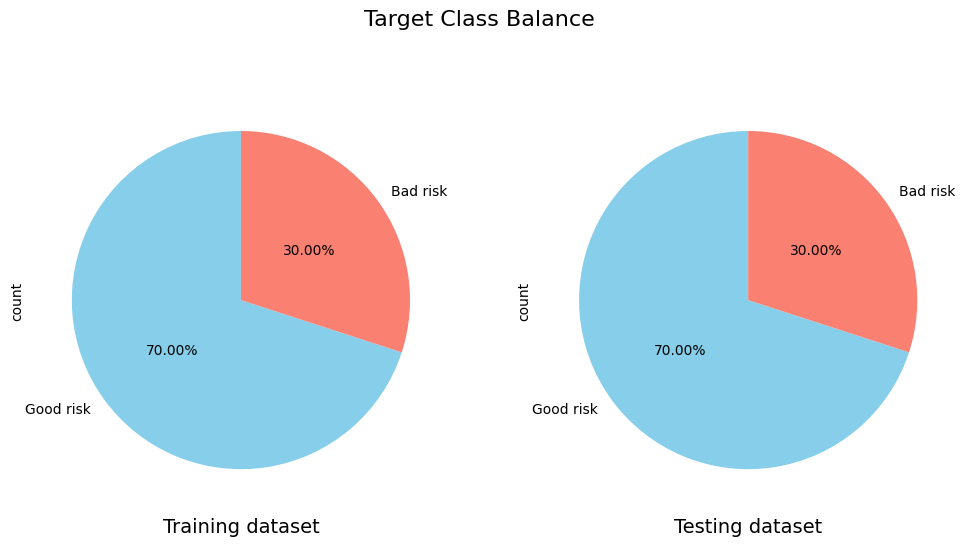

In [87]:
# Train - Test distribution
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
y_train.value_counts().plot(kind = 'pie',
                            autopct = '%.2f%%',
                            startangle = 90,
                            labels = ['Good risk', 'Bad risk'],
                            pctdistance = 0.5,
                            colors = ['skyblue', 'salmon'])
plt.xlabel('Training dataset', fontsize = 14)

plt.subplot(1, 2, 2)
y_test.value_counts().plot(kind = 'pie',
                           autopct = '%.2f%%',
                           startangle = 90,
                           labels = ['Good risk', 'Bad risk'],
                           pctdistance = 0.5, 
                           colors = ['skyblue', 'salmon'])

plt.xlabel('Testing dataset', fontsize = 14)

plt.suptitle('Target Class Balance', fontsize = 16)
plt.show()

## 1.4 **Data pre-processing**

### 1.4.1 **Outliers**

As we saw earlier in univariate analysis, CreditAmount contains (few) outliers so we have to treat them as the presence of outliers affects the distribution of the data. Having outliers in the dataset often has a significant effect on the mean and standard deviation and hence affecting the distribution. We must take steps to remove outliers from our data sets.

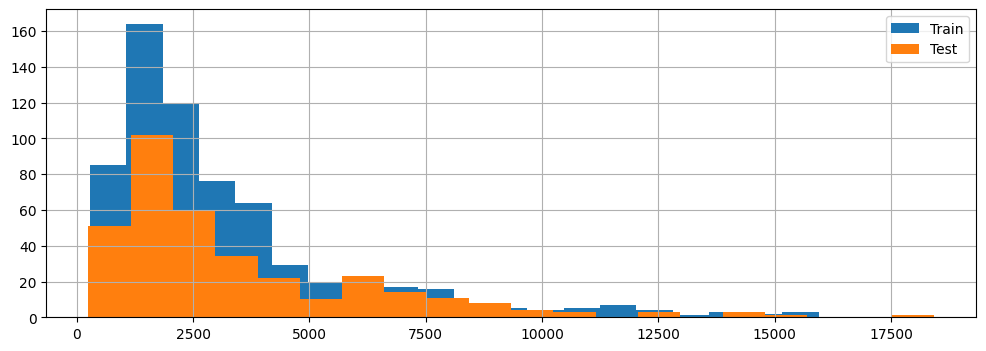

In [88]:
X_train['Credit amount'].hist(bins=20, figsize=(12,4), label='Train')
X_test['Credit amount'].hist(bins=20, figsize=(12,4), label='Test')
plt.legend()
plt.show()

In [89]:
# Removing skewness in LoanAmount variable by log transformation
X_train['CreditAmount_log'] = np.log(X_train['Credit amount'])
X_train.drop(columns=['Credit amount'], inplace=True)

X_test['CreditAmount_log'] = np.log(X_test['Credit amount'])
X_test.drop(columns=['Credit amount'], inplace=True)

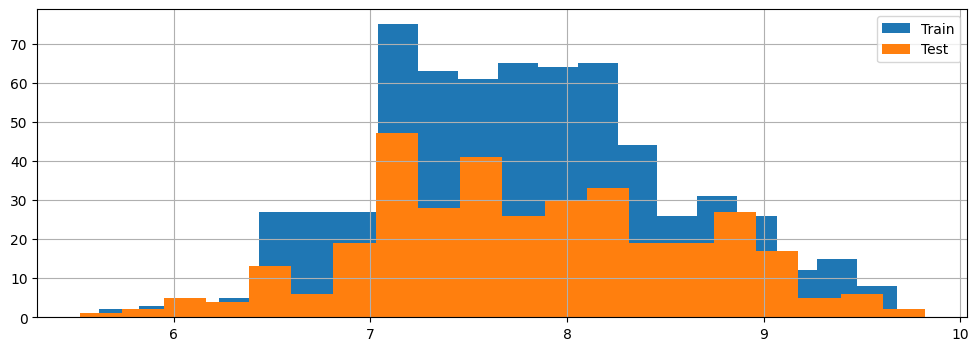

In [90]:
X_train['CreditAmount_log'].hist(bins=20, figsize=(12,4), label='Train')
X_test['CreditAmount_log'].hist(bins=20, figsize=(12,4), label='Test')
plt.legend()
plt.show()

# 2. **Baseline Model**

In order to effectively manage any existing biases, we decide to use a Decision Tree Classifier model as a baseline and then utilize the Fairlearn package to assess its fairness.


In [91]:
from sklearn.tree import DecisionTreeClassifier

baseline = DecisionTreeClassifier(random_state=random_seed)
baseline.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1234)

In [92]:
print('Train accuracy:', baseline.score(X_train, y_train))
print('Test accuracy:', baseline.score(X_test, y_test))

Train accuracy: 1.0
Test accuracy: 0.6542857142857142


# 3. **Fairness Evaluation**

The use of **Fairlearn** package allows us to verify if there are discriminations that affect a particular group of people by comparing the data regarding these groups with those concerning the response of the population.

Therefore, it is necessary to define the type of grouping that we want to perform on the population. In our case, we investigate gender discriminations. So, the objective is to ensure that neither gender exhibits significantly higher false-positive or false-negative rates than other groups.

To evaluate the model's performance, we have decided to use the **balanced accuracy** and apply the following fairness metrics:
- **Demographic Parity**: asserts that each segment of a protected feature (e.g., gender) should receive positive outcomes at equal rates ( both true positive rates and false positive rates )
- **Equalized Odds**: the model should accurately identify positive outcomes at equal rates across groups, while also misclassifying positive outcomes at equal rates across groups, thus generating the same proportion of False Positives across groups.
- **Equal opportunity**: This metric focuses specifically on ensuring parity in the true positive rates across different demographic groups. It means that the model should correctly identify positive outcomes

In [93]:
def calculate_metrics(y_true, y_pred, sensitive_features, metric_frame, column_name):
    '''
        Calculate fairness and accuracy metrics.
        Args:
            y_true: the true labels
            y_pred: the predicted labels
            sensitive_features: the sensitive features
        Returns:
            metrics: a dictionary containing the metrics
    '''
    
    metrics = {}
    metrics["Balanced Accuracy"] = balanced_accuracy_score(y_true, y_pred)
    metrics["Equalize Odds Difference"] = flm.equalized_odds_difference(y_true, y_pred, sensitive_features=sensitive_features)
    metrics["Selection Rate"] = flm.selection_rate(y_true, y_pred)
    metrics["Demographic Parity Difference"] = flm.demographic_parity_difference(y_true, baseline.predict(X_test), sensitive_features=sensitive_features)
    return pd.DataFrame(metrics, index=[column_name]).T

def set_metrics_frame(y_true, y_pred, sensitive_features):
    '''
        Set the metrics frame for the given model considering the sensitive features.
        Args:
            y_true: the true labels
            y_pred: the predicted labels
            sensitive_features: the sensitive features
            column_name: the name of the model
        Returns:
            metric_frame: the metrics frame
    '''
    metric_frame = MetricFrame(metrics = {
        'Balanced accuracy': balanced_accuracy_score,
        'Selection Rate': flm.selection_rate,
        'precision (calibration)': skm.precision_score,
        'recall (equal opportunity)': skm.recall_score,
        'false_positive_rate': flm.false_positive_rate,
        'false_negative_rate': flm.false_negative_rate,
    }, y_true=y_true, y_pred=y_pred, sensitive_features=sensitive_features)

    return metric_frame 

In [94]:
y_pred_baseline = baseline.predict(X_test)
metricframe_baseline = set_metrics_frame(y_test, y_pred_baseline, A_test)
fairlearn_baseline_metrics = calculate_metrics(y_test, y_pred_baseline, A_test, metricframe_baseline.by_group, "Unmitigated")
fairlearn_baseline_metrics

,Unmitigated
Balanced Accuracy,0.606122
Equalize Odds Difference,0.184206
Selection Rate,0.662857
Demographic Parity Difference,0.132470


**Performance Metrics:**
- The **balance accuracy** score of (0.60) indicates that the model has a fair ability to distinguish between the positive and negative classes. 
We should consider that an accuracy of 0.5 represents a random classifier, while an accuracy of 1.0 represents a perfect classifier. Thus,our score is above average but not extremely high.


**Fairness Metrics**

- **Equalized Odds Difference (0.18)**: equalized odds measure the difference in false positive rates and false negative rates across groups, it indicates that there is a 18% discrepancy in these rates between groups, suggesting some inequality in how errors are distributed. 

- **Selection Rate (0.66)**:  This metric does not directly indicate fairness but shows the proportion of positive predictions, in this case a selection rate of 66.28% suggests that roughly two-thirds of the applicants receive positive outcomes.

- **Demographic Parity Difference** (0.13): there is 14% disparity in the selection rates (positive outcomes) between groups.  Higher difference implies a more significant bias, where certain groups are more likely to receive positive outcomes than others.

In [95]:
def inverse_trasformation_gender(gender_list):
    reversed_gender_list = ['Male' if gender == 1 else 'Female' for gender in gender_list]
    return reversed_gender_list

In [96]:
metricframe_baseline.by_group.index = inverse_trasformation_gender(metricframe_baseline.by_group.index)
metricframe_baseline.by_group

,Balanced accuracy,Selection Rate,precision (calibration),recall (equal opportunity),false_positive_rate,false_negative_rate
Female,0.525362,0.573913,0.621212,0.594203,0.543478,0.405797
Male,0.643442,0.706383,0.825301,0.778409,0.491525,0.221591


The printed metricframe highlights that:
- a larger proportion of males are selected by the model compared to females (selection rate)
- the model is more accurate in predicting positive instances for males (calibration)
- the model is better at identifying positive instances for males (equal opportunity)

In [97]:
metricframe_baseline.difference()

Balanced accuracy             0.118080
Selection Rate                0.132470
precision (calibration)       0.204089
recall (equal opportunity)    0.184206
false_positive_rate           0.051953
false_negative_rate           0.184206
dtype: float64

In [98]:
metricframe_baseline.overall

Balanced accuracy             0.606122
Selection Rate                0.662857
precision (calibration)       0.767241
recall (equal opportunity)    0.726531
false_positive_rate           0.514286
false_negative_rate           0.273469
dtype: float64

array([[<Axes: title={'center': 'Balanced accuracy'}>,
        <Axes: title={'center': 'false_negative_rate'}>,
        <Axes: title={'center': 'false_positive_rate'}>]], dtype=object)

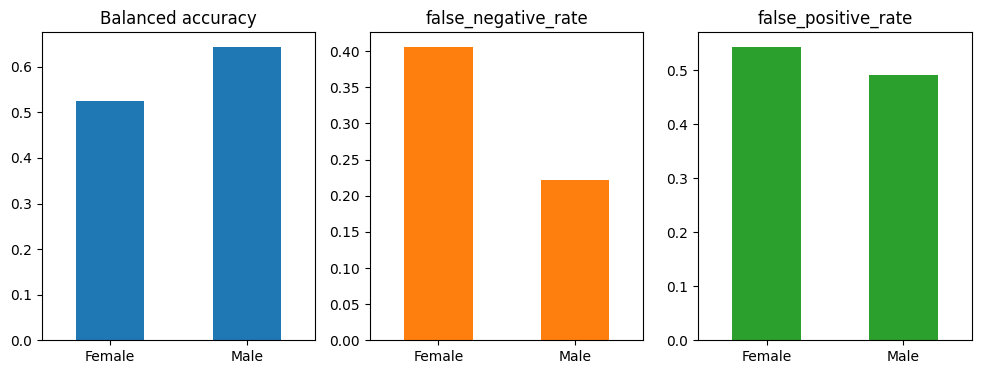

In [99]:
metricframe_baseline.by_group[['Balanced accuracy', 'false_negative_rate', 'false_positive_rate']].plot.bar(
    subplots=True, layout=[1, 3], figsize=[12, 4], legend=None, rot=0
)

# 4. **Mitigation techniques**

## 4a. Inprocess mititgation: **Grid Search**

As first approach we decided to mitigate the bias through the Fairlearn's GridSearch method, which systematically searches for the best trade-offs between fairness and performance.

In [100]:
from fairlearn.reductions import EqualizedOdds

grid_search = GridSearch(baseline,
                   constraints=EqualizedOdds(),
                   grid_size=600,
                   grid_limit=5)
grid_search.fit(X_train, y_train, sensitive_features=A_train)
calibrated_predictors = []
for pred in grid_search.predictors_:
    calibrated = CalibratedClassifierCV(pred, cv='prefit')
    calibrated.fit(X_train, y_train)
    calibrated_predictors.append(calibrated)

In [101]:
def calculate_cdf(data, num_bins, limits):
    return cumfreq(data, numbins=num_bins, defaultreallimits=limits)

def compare_cumulative_distributions(predictions, groups, num_bins=100):
    group_cdfs = {}
    
    min_val = np.min(predictions)
    max_val = np.max(predictions)
    scale_factor = 0.5 * (max_val - min_val) / (num_bins - 1)
    limits = (min_val - scale_factor, max_val + scale_factor)
    
    for group in np.unique(groups):
        group_subset = predictions[groups == group]
        group_cdfs[group] = calculate_cdf(group_subset, num_bins, limits)
        
    lower_limits = [cdf.lowerlimit for cdf in group_cdfs.values()]
    bin_sizes = [cdf.binsize for cdf in group_cdfs.values()]
    
    x_values = lower_limits[0] + np.linspace(0, bin_sizes[0] * num_bins, num_bins)
    
    disparities = np.zeros(num_bins)
    for i in range(num_bins):
        cdf_values = np.clip([cdf.cumcount[i] / len(predictions[groups == group]) for group, cdf in group_cdfs.items()], 0, 1)
        disparities[i] = np.max(cdf_values) - np.min(cdf_values)
    
    return x_values, group_cdfs, disparities


In [102]:
def plot_and_compare_cdfs(data, groups, num_bins=100, loc='best'):
    x_values, group_cdfs, disparities = compare_cumulative_distributions(data, groups, num_bins)
    
    for group, cdf in group_cdfs.items():
        plt.plot(x_values, cdf.cumcount / len(data[groups == group]), label=f'Group {group}')
    
    d_idx = disparities.argmax()
    if disparities[d_idx] > 0:
        x_disparity = [x_values[d_idx], x_values[d_idx]]
        y_disparity = [min(cdf.cumcount[d_idx] / len(data[groups == group]) for group, cdf in group_cdfs.items()), 
                       max(cdf.cumcount[d_idx] / len(data[groups == group]) for group, cdf in group_cdfs.items())]
        plt.plot(x_disparity, y_disparity, 'o--', label=f'Max disparity = {disparities[d_idx]:.3f}\nat {x_values[d_idx]:.3f}')
    
    plt.xlabel(data.name if hasattr(data, 'name') else "Data")
    plt.ylabel("Cumulative Frequency")
    plt.legend(loc=loc)
    plt.title("Cumulative Distribution Function (CDF) Comparison")
    plt.show()

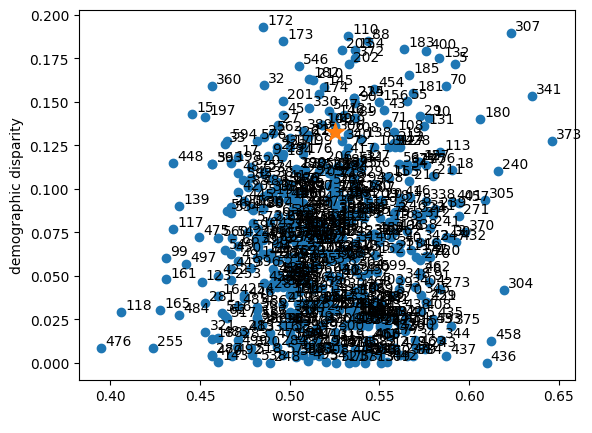

In [103]:
def auc_disparity_plot(predictors, names, marker='o', scale_size=1, zorder=-1):
    roc_auc = []
    disparity = []
    
    for i in range(len(predictors)):
        preds = predictors[i].predict_proba(X_test)[:,1]
        metric_frame = MetricFrame(metrics = {
                'AUC': roc_auc_score,
               
            }, y_true=y_test, y_pred=preds, sensitive_features=A_test)

        roc_auc.append(min(metric_frame.by_group["AUC"].values))
        _, _, dis = compare_cumulative_distributions(preds, A_test)
        disparity.append(dis.max())
        
    plt.scatter(roc_auc, disparity,
                s=scale_size * plt.rcParams['lines.markersize'] ** 2, marker=marker, zorder=zorder)
    for i in range(len(roc_auc)):
        plt.annotate(names[i], (roc_auc[i], disparity[i]), xytext=(3,2), textcoords="offset points", zorder=zorder+1)
    plt.xlabel("worst-case AUC")
    plt.ylabel("demographic disparity")
    
auc_disparity_plot(calibrated_predictors, names=range(len(calibrated_predictors)))
auc_disparity_plot([baseline], names=[''], marker='*', zorder=1, scale_size=5)
plt.show()

## 4b. Postprocessing mitigations: **ThresholdOptimizer**

**ThresholdOptimizer** adjusts the decision threshold of a model's predicted probabilities to achieve certain fairness or performance criteria. 

Overview:
- *Predicted Probabilities*: First, the ML model generates predicted probabilities for each class.

- *Threshold Optimization*: The ThresholdOptimizer algorithm adjusts the decision threshold for classification based on predefined fairness metrics. 

- *Evaluation and Refinement*: After adjusting the thresholds, the model's performance is evaluated using both fairness and traditional metrics.

- *Iterative Process*: Threshold optimization may involve an iterative process of adjusting thresholds, evaluating model performance, and refining criteria until satisfactory fairness and performance outcomes are achieved.

We aim to optimize the **balanced_accuracy** under some fairness constraint, the **demographic parity**.

In [104]:
from fairlearn.postprocessing import ThresholdOptimizer

postprocess_est = ThresholdOptimizer(
    estimator=baseline,
    constraints= 'demographic_parity',
    objective="accuracy_score",  
    prefit=True,
    predict_method="predict_proba"
)

In [105]:
postprocess_est.fit(X=X_train, y=y_train, sensitive_features=A_train)
postprocess_pred = postprocess_est.predict(X_test, sensitive_features=A_test, random_state=random_seed)

In [107]:
from fairlearn.postprocessing import plot_threshold_optimizer

# Plot the chosen solution of the threshold optimizer
plot_threshold_optimizer(postprocess_est, ax=None, show_plot=True)

TypeError: plot_threshold_optimizer() got an unexpected keyword argument 'color'

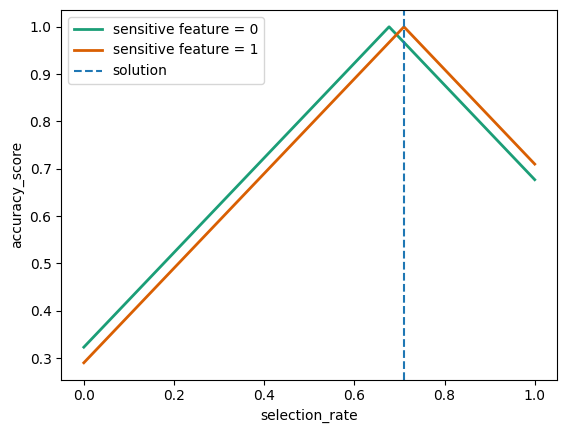

In [119]:
color_to_set = 'white'

fig, ax = plt.subplots()
ax.set_facecolor(color_to_set)  # Set background color
fig.patch.set_facecolor(color_to_set)  # Set background color
plot_threshold_optimizer(postprocess_est, ax=ax, show_plot=True)

plt.show()


- Each curve represents a different demographic group (0: females, 1: males)
- Shows how the accuracy score changes as the selection rate varies for each group.
- The threshold is chosen as the point where the balance between accuracy and selection rate is optimized according to the chosen fairness constraint.

## 4c. Inprocessing mitigation: **ExponentiatedGradient**

EGR is an optimization method that updates model parameters using an exponentiated gradient approach.
It balances the trade-off between minimizing loss and satisfying fairness constraints.

In [52]:
from aif360.sklearn.inprocessing import ExponentiatedGradientReduction

exponentiated_gradient = ExponentiatedGradientReduction(estimator = baseline,
                                                        prot_attr='Sex',
                                                        constraints=EqualizedOdds(), 
                                                        drop_prot_attr=True
                                                        )

pip install 'aif360[inFairness]'


In [53]:
X_train_a = X_train.copy()
X_train_a["Sex"] = A_train

X_test_a = X_test.copy()
X_test_a["Sex"] = A_test

In [54]:
exponentiated_gradient.fit(X_train_a, y_train) 
y_expo_pred = exponentiated_gradient.predict(X_test_a)

## 4d. Inprocess mitigation: **Prejudice removal**

The Prejudice Remover technique is a in-processing method designed to mitigate biases present within machine learning models. It achieves this by augmenting the model's learning objective with a discrimination-aware regularization term, which acts as a penalty for decisions that may contribute to discrimination or bias. By integrating this specialized regularization term into the model's training process, the Prejudice Remover encourages the model to learn decision boundaries that are more fair and equitable across different demographic groups. 

In [55]:
from aif360.algorithms.inprocessing import PrejudiceRemover
from aif360.datasets import BinaryLabelDataset

In [56]:
df_train = X_train.copy()
df_train['Risk'] = y_train
df_train['Sex'] = A_train

df_test = X_test.copy()
df_test['Risk'] = y_test
df_test['Sex'] = A_test

privileged_groups = [{'Sex': 1}]
unprivileged_groups = [{'Sex': 0}]
label_name = 'Risk'
protected_attribute_name = 'Sex'

train_dataset = BinaryLabelDataset(
    df=df_train,
    label_names=[label_name],
    protected_attribute_names=[protected_attribute_name]
)

test_dataset = BinaryLabelDataset(
    df=df_test,
    label_names=[label_name],
    protected_attribute_names=[protected_attribute_name]
)

In [57]:
pr = PrejudiceRemover(sensitive_attr='Sex', eta=30.0)
pr.fit(train_dataset)
y_pred_pr = pr.predict(test_dataset).labels.ravel()

## 4e. Inprocess mitigation: Adversial Biases

This technique leverages the use of two different models:
- A primary model that predicts outcomes based on input data and which is the model we are trying to make unbiased.
- An adversary model that tries to detect biases in the predictions of the primary model.

The primary model focuses both on prediction accuracy and reducing bias, while the adversary focuses solely on detecting bias in the primary model.

This setup encourages the primary model to be both accurate and fair.

In [58]:
from aif360.algorithms.inprocessing import AdversarialDebiasing
import tensorflow as tf

tf.compat.v1.disable_eager_execution()
with tf.compat.v1.variable_scope('adversarial_debiasing', reuse=tf.compat.v1.AUTO_REUSE):
    adversial_debias = AdversarialDebiasing(unprivileged_groups=unprivileged_groups,
                                        privileged_groups=privileged_groups,
                                        scope_name='adversarial_debiasing',
                                        num_epochs=100,
                                        batch_size=128,
                                        debias=True,
                                        adversary_loss_weight = 0.001,
                                        sess=tf.compat.v1.Session())

adversial_debias.fit(train_dataset)
y_pred_ad = adversial_debias.predict(test_dataset)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


epoch 0; iter: 0; batch classifier loss: 0.797995; batch adversarial loss: 0.695481
epoch 1; iter: 0; batch classifier loss: 0.808308; batch adversarial loss: 0.699971
epoch 2; iter: 0; batch classifier loss: 0.826304; batch adversarial loss: 0.692988
epoch 3; iter: 0; batch classifier loss: 0.628824; batch adversarial loss: 0.685870
epoch 4; iter: 0; batch classifier loss: 0.671399; batch adversarial loss: 0.689298
epoch 5; iter: 0; batch classifier loss: 0.675152; batch adversarial loss: 0.687999
epoch 6; iter: 0; batch classifier loss: 0.681920; batch adversarial loss: 0.684434
epoch 7; iter: 0; batch classifier loss: 0.697751; batch adversarial loss: 0.685156
epoch 8; iter: 0; batch classifier loss: 0.635931; batch adversarial loss: 0.681736
epoch 9; iter: 0; batch classifier loss: 0.685574; batch adversarial loss: 0.677402
epoch 10; iter: 0; batch classifier loss: 0.650637; batch adversarial loss: 0.676810
epoch 11; iter: 0; batch classifier loss: 0.587882; batch adversarial loss:

In [59]:
y_pred_ad = y_pred_ad.labels.ravel()

# Results

In [60]:
def plot_cm(y_true, y_pred, ax, title, normalize=True):
    """
    Plot the confusion matrix.
    """
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2%', ax=ax)
    else:
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title(title)

In [61]:
def evaluate_model(predictor, A_test, X_test, y_test, title):
    """
    Evaluate the model using the confusion matrix and fairness metrics.
    """
    fig, ax = plt.subplots(figsize=(5, 4))
    if title == 'Threshold Optimizer':
        y_pred = predictor.predict(X_test, sensitive_features=A_test)
    else:
        y_pred = predictor.predict(X_test)
    plot_cm(y_test, y_pred, ax, title=f'Confusion Matrix {title}', normalize=True)
    
    # Plot the confusion matrix for male and female applicants (0: Female - 1: Male) 
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    map_value_gender = {0: 'Female', 1: 'Male'}

    for i, ax in enumerate(axes):
        gender = map_value_gender[i]
        indices = A_test[A_test == i].index

        if title == 'Threshold Optimizer':
            y_pred_gender = predictor.predict(X_test.loc[indices], sensitive_features=A_test.loc[indices])
        else:
            y_pred_gender = predictor.predict(X_test.loc[indices])
        
        y_true_gender = y_test.loc[indices]
        plot_cm(y_true_gender, y_pred_gender, ax, title=f'Confusion Matrix for {gender} Applicants - {title}', normalize=True)

    plt.show()

    metricframe = set_metrics_frame(y_test, y_pred, A_test)
    fairlearn_metrics = calculate_metrics(y_test, y_pred, A_test, metricframe_baseline.by_group, title)
    
    return metricframe, fairlearn_metrics

## Baseline

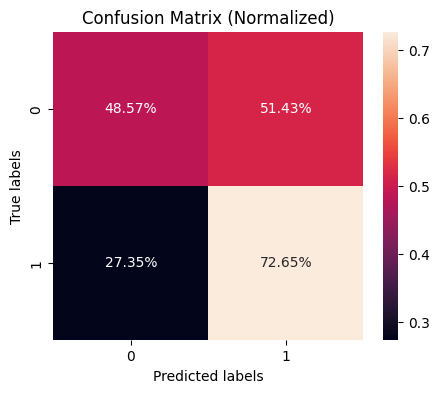

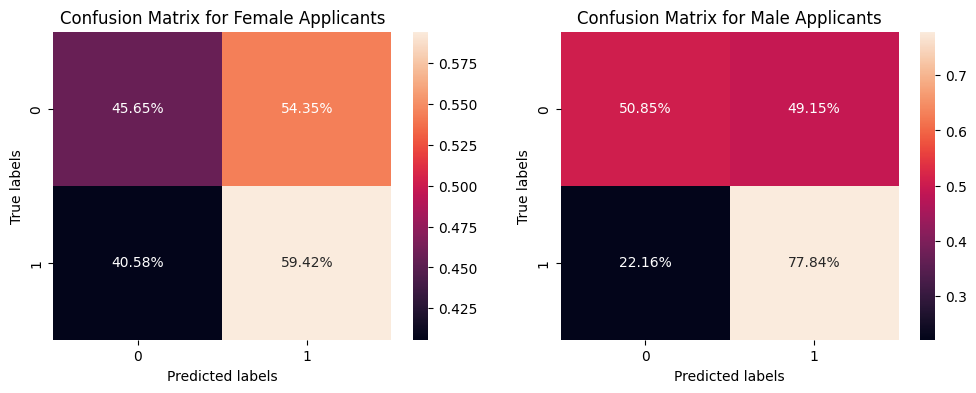

In [62]:
fig, ax = plt.subplots(figsize=(5, 4))
plot_cm(y_test, y_pred_baseline, ax, title='Confusion Matrix (Normalized)', normalize=True)

# Plot the confusion matrix for male and female applicants (0: Female - 1: Male) 
map_value_gender = {0: 'Female', 1: 'Male'}
map_gender_value = {'Female': 0, 'Male': 1}

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for i, ax in enumerate(axes):
    gender = map_value_gender[i]
    indices = A_test[A_test == i].index

    y_pred_gender = baseline.predict(X_test.loc[indices])
    y_true_gender = y_test.loc[indices]
    plot_cm(y_true_gender, y_pred_gender, ax, title=f'Confusion Matrix for {gender} Applicants', normalize=True)

plt.show()

## Grid Search

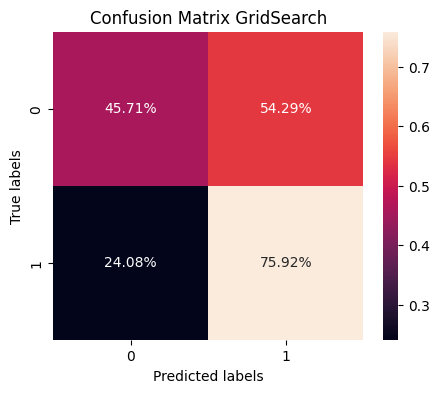

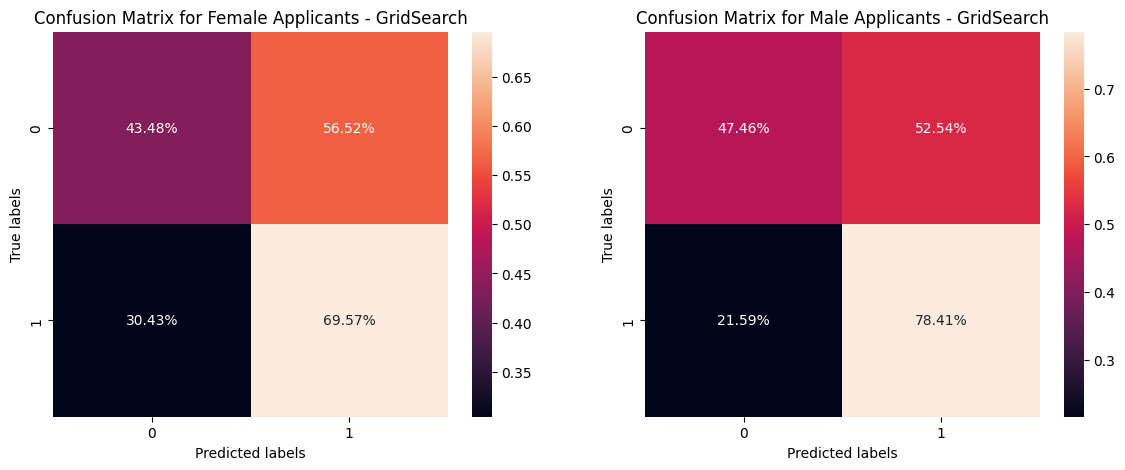

,GridSearch
Balanced Accuracy,0.608163
Equalize Odds Difference,0.088439
Selection Rate,0.694286
Demographic Parity Difference,0.132470


In [63]:
best_model = calibrated_predictors[grid_search.best_idx_]
metricframe_grids, fairlearn_grids_metrics = evaluate_model(best_model, A_test, X_test, y_test, title='GridSearch')
fairness_metrics = pd.concat([fairlearn_baseline_metrics, fairlearn_grids_metrics], axis=1)
display(fairlearn_grids_metrics)

In [64]:
metricframe_grids.by_group.index = inverse_trasformation_gender(metricframe_grids.by_group.index)
metricframe_grids.by_group

,Balanced accuracy,Selection Rate,precision (calibration),recall (equal opportunity),false_positive_rate,false_negative_rate
Female,0.565217,0.643478,0.648649,0.695652,0.565217,0.304348
Male,0.629334,0.719149,0.816568,0.784091,0.525424,0.215909


array([[<Axes: title={'center': 'Balanced accuracy'}>,
        <Axes: title={'center': 'false_negative_rate'}>,
        <Axes: title={'center': 'false_positive_rate'}>]], dtype=object)

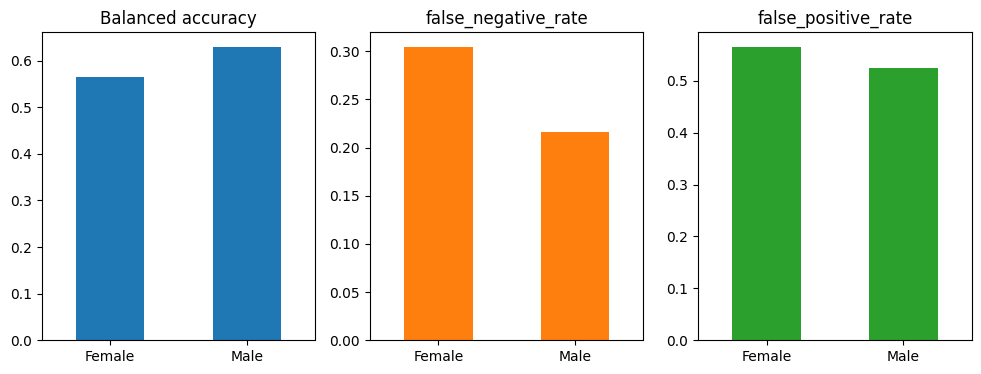

In [65]:
metricframe_grids.by_group[['Balanced accuracy', 'false_negative_rate', 'false_positive_rate']].plot.bar(
    subplots=True, layout=[1, 3], figsize=[12, 4], legend=None, rot=0
)

## Threshold Optimizer

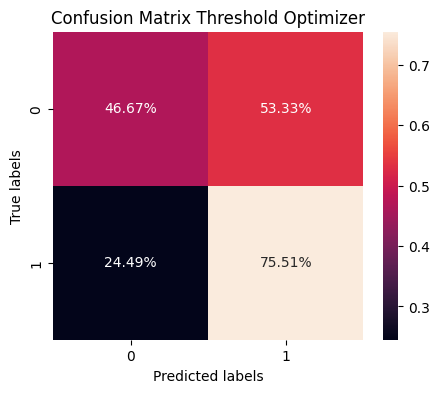

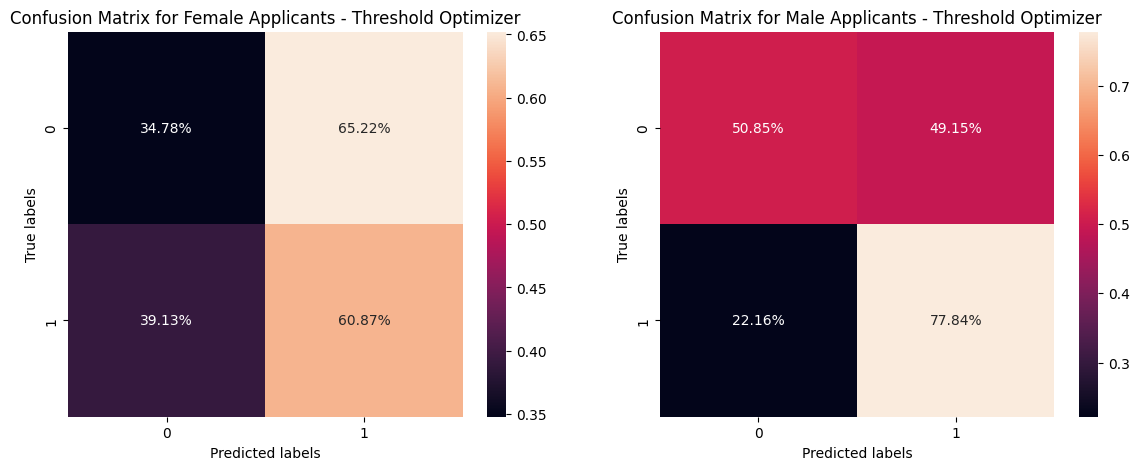

,Threshold Optimizer
Balanced Accuracy,0.610884
Equalize Odds Difference,0.095431
Selection Rate,0.688571
Demographic Parity Difference,0.132470


In [66]:
metricframe_thrOpt, fairlearn_thrOpt_metrics = evaluate_model(postprocess_est, A_test, X_test, y_test, title='Threshold Optimizer')
fairness_metrics = pd.concat([fairness_metrics, fairlearn_thrOpt_metrics], axis=1)
display(fairlearn_thrOpt_metrics)

In [67]:
metricframe_thrOpt.by_group.index = inverse_trasformation_gender(metricframe_thrOpt.by_group.index)
metricframe_thrOpt.by_group

,Balanced accuracy,Selection Rate,precision (calibration),recall (equal opportunity),false_positive_rate,false_negative_rate
Female,0.554348,0.652174,0.640000,0.695652,0.586957,0.304348
Male,0.643442,0.706383,0.825301,0.778409,0.491525,0.221591


array([[<Axes: title={'center': 'Balanced accuracy'}>,
        <Axes: title={'center': 'false_negative_rate'}>,
        <Axes: title={'center': 'false_positive_rate'}>]], dtype=object)

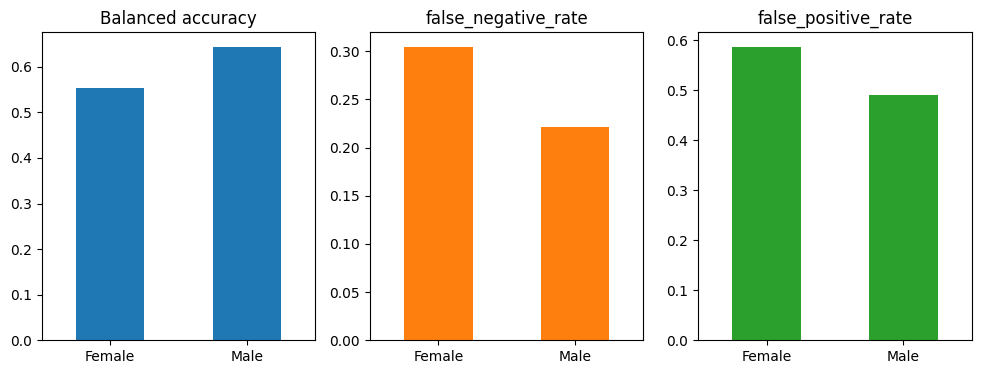

In [68]:
metricframe_thrOpt.by_group[['Balanced accuracy', 'false_negative_rate', 'false_positive_rate']].plot.bar(
    subplots=True, layout=[1, 3], figsize=[12, 4], legend=None, rot=0
)

## Exponential Gradient

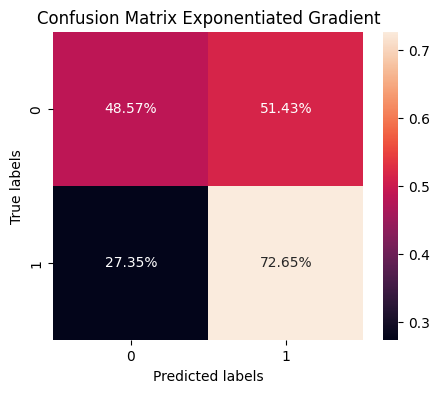

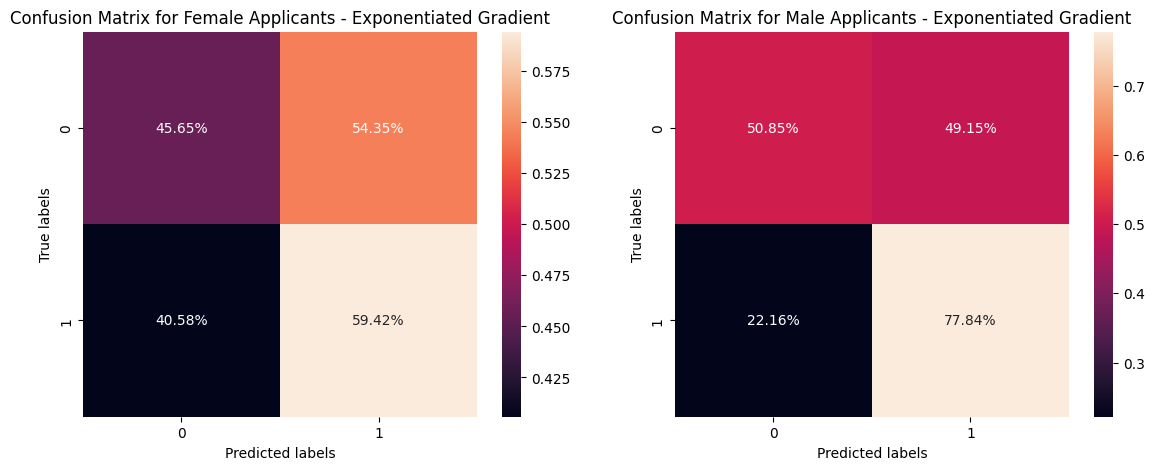

,Exponentiated Gradient
Balanced Accuracy,0.606122
Equalize Odds Difference,0.184206
Selection Rate,0.662857
Demographic Parity Difference,0.132470


In [69]:
metricframe_exp, fairlearn_exp_metrics = evaluate_model(exponentiated_gradient, A_test, X_test_a, y_test, title='Exponentiated Gradient')
fairness_metrics = pd.concat([fairness_metrics, fairlearn_exp_metrics], axis=1)
display(fairlearn_exp_metrics)

In [70]:
metricframe_exp.by_group.index = inverse_trasformation_gender(metricframe_exp.by_group.index)
metricframe_exp.by_group

,Balanced accuracy,Selection Rate,precision (calibration),recall (equal opportunity),false_positive_rate,false_negative_rate
Female,0.525362,0.573913,0.621212,0.594203,0.543478,0.405797
Male,0.643442,0.706383,0.825301,0.778409,0.491525,0.221591


array([[<Axes: title={'center': 'Balanced accuracy'}>,
        <Axes: title={'center': 'false_negative_rate'}>,
        <Axes: title={'center': 'false_positive_rate'}>]], dtype=object)

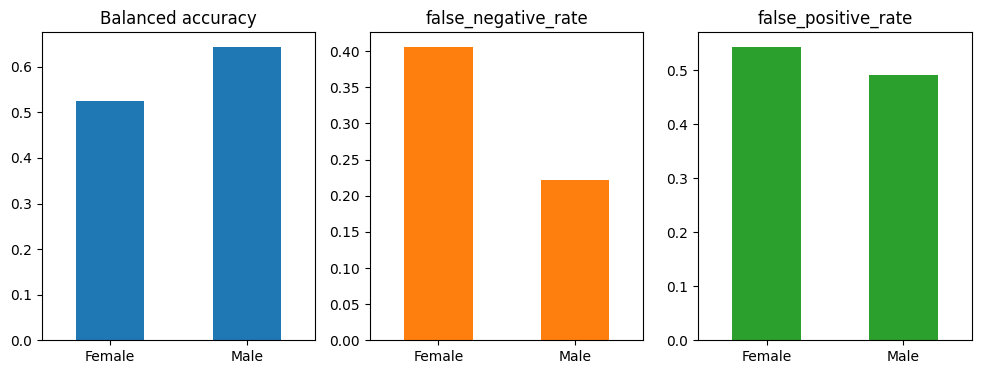

In [71]:
metricframe_exp.by_group[['Balanced accuracy', 'false_negative_rate', 'false_positive_rate']].plot.bar(
    subplots=True, layout=[1, 3], figsize=[12, 4], legend=None, rot=0
)

## Prejudice removal

,Prejudice Remover
Balanced Accuracy,0.639456
Equalize Odds Difference,0.181324
Selection Rate,0.785714
Demographic Parity Difference,0.132470


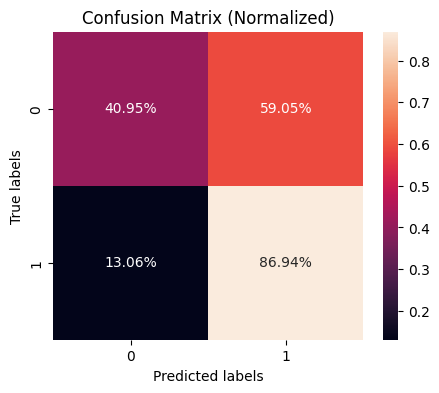

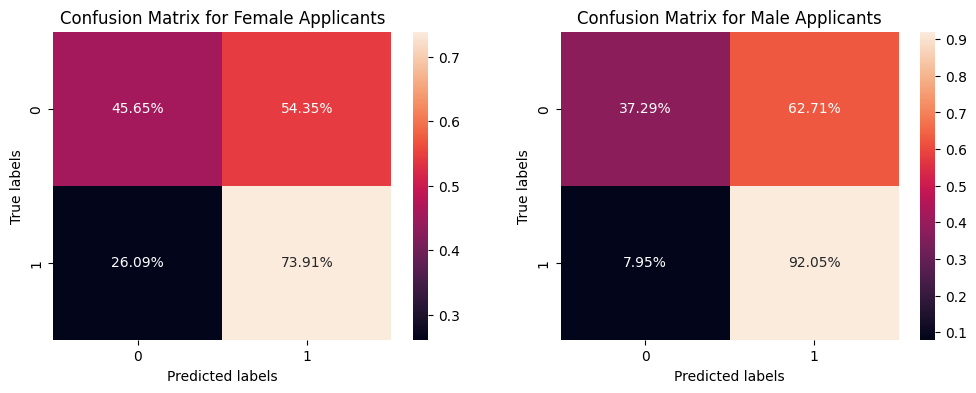

In [72]:
metricframe_pr, fairlearn_pr_metrics = set_metrics_frame(y_test, y_pred_pr, A_test), calculate_metrics(y_test, y_pred_pr, A_test, metricframe_baseline.by_group, 'Prejudice Remover')
fairness_metrics = pd.concat([fairness_metrics, fairlearn_pr_metrics], axis=1)
display(fairlearn_pr_metrics)


fig, ax = plt.subplots(figsize=(5, 4))
plot_cm(y_test, y_pred_pr, ax, title='Confusion Matrix (Normalized)', normalize=True)

# # Plot the confusion matrix for male and female applicants (0: Female - 1: Male) 
map_value_gender = {0: 'Female', 1: 'Male'}
map_gender_value = {'Female': 0, 'Male': 1}

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

original_indices = A_test.index
positional_index_mapping = {original_idx: pos for pos, original_idx in enumerate(original_indices)}

for i, ax in enumerate(axes):
    if i not in map_value_gender:
        continue
    gender = map_value_gender[i]
    indices = A_test[A_test == i].index

    # Convert to positional indices
    positional_indices = [positional_index_mapping[idx] for idx in indices]

    # Filter dataset by gender
    gender_dataset = test_dataset.subset(positional_indices)
    y_pred_gender = pr.predict(gender_dataset).labels
    y_true_gender = y_test.loc[indices]
    
    plot_cm(y_true_gender, y_pred_gender, ax, title=f'Confusion Matrix for {gender} Applicants', normalize=True)

plt.show()

In [73]:
metricframe_pr.by_group.index = inverse_trasformation_gender(metricframe_pr.by_group.index)
metricframe_pr.by_group

,Balanced accuracy,Selection Rate,precision (calibration),recall (equal opportunity),false_positive_rate,false_negative_rate
Female,0.597826,0.660870,0.671053,0.739130,0.543478,0.260870
Male,0.646668,0.846809,0.814070,0.920455,0.627119,0.079545


array([[<Axes: title={'center': 'Balanced accuracy'}>,
        <Axes: title={'center': 'false_negative_rate'}>,
        <Axes: title={'center': 'false_positive_rate'}>]], dtype=object)

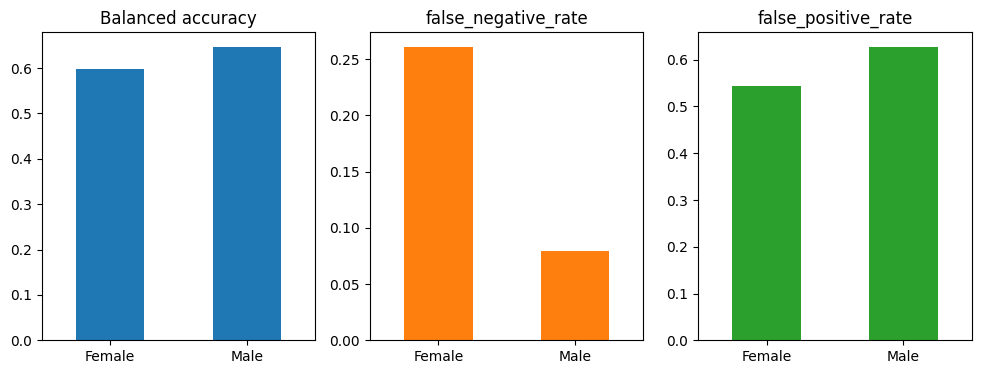

In [74]:
metricframe_pr.by_group[['Balanced accuracy', 'false_negative_rate', 'false_positive_rate']].plot.bar(
    subplots=True, layout=[1, 3], figsize=[12, 4], legend=None, rot=0
)

## Adversial Biases

,Adversial Debiasing
Balanced Accuracy,0.616327
Equalize Odds Difference,0.108284
Selection Rate,0.848571
Demographic Parity Difference,0.132470


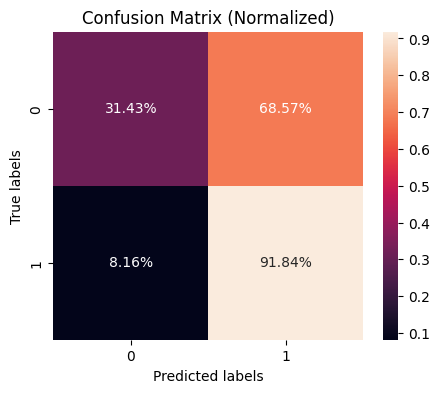

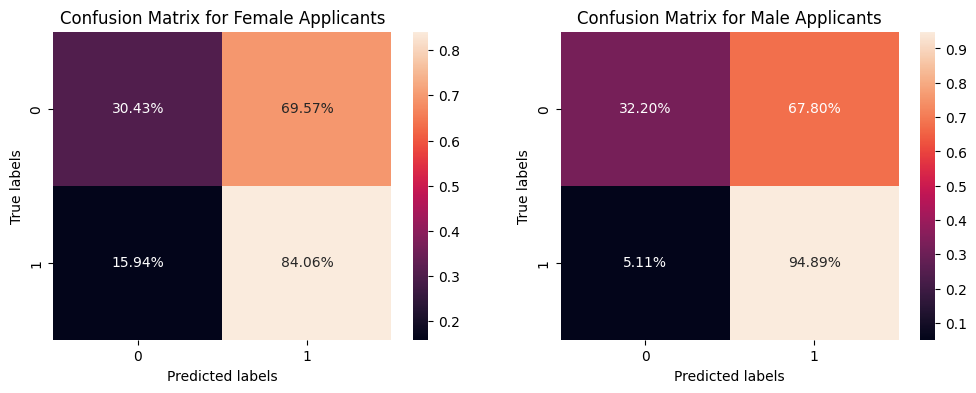

In [75]:
metricframe_ad, fairlearn_ad_metrics = set_metrics_frame(y_test, y_pred_ad, A_test), calculate_metrics(y_test, y_pred_ad, A_test, metricframe_baseline.by_group, 'Adversial Debiasing')
fairness_metrics = pd.concat([fairness_metrics, fairlearn_ad_metrics], axis=1)
display(fairlearn_ad_metrics)

fig, ax = plt.subplots(figsize=(5, 4))
plot_cm(y_test, y_pred_ad, ax, title='Confusion Matrix (Normalized)', normalize=True)

# # Plot the confusion matrix for male and female applicants (0: Female - 1: Male) 
map_value_gender = {0: 'Female', 1: 'Male'}
map_gender_value = {'Female': 0, 'Male': 1}

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

original_indices = A_test.index
positional_index_mapping = {original_idx: pos for pos, original_idx in enumerate(original_indices)}

for i, ax in enumerate(axes):
    if i not in map_value_gender:
        continue
    gender = map_value_gender[i]
    indices = A_test[A_test == i].index

    # Convert to positional indices
    positional_indices = [positional_index_mapping[idx] for idx in indices]

    # Filter dataset by gender
    gender_dataset = test_dataset.subset(positional_indices)
    y_pred_gender = adversial_debias.predict(gender_dataset).labels
    y_true_gender = y_test.loc[indices]
    
    plot_cm(y_true_gender, y_pred_gender, ax, title=f'Confusion Matrix for {gender} Applicants', normalize=True)

plt.show()

In [76]:
metricframe_ad.by_group.index = inverse_trasformation_gender(metricframe_ad.by_group.index)
metricframe_ad.by_group

,Balanced accuracy,Selection Rate,precision (calibration),recall (equal opportunity),false_positive_rate,false_negative_rate
Female,0.572464,0.782609,0.644444,0.840580,0.695652,0.159420
Male,0.635449,0.880851,0.806763,0.948864,0.677966,0.051136


array([[<Axes: title={'center': 'Balanced accuracy'}>,
        <Axes: title={'center': 'false_negative_rate'}>,
        <Axes: title={'center': 'false_positive_rate'}>]], dtype=object)

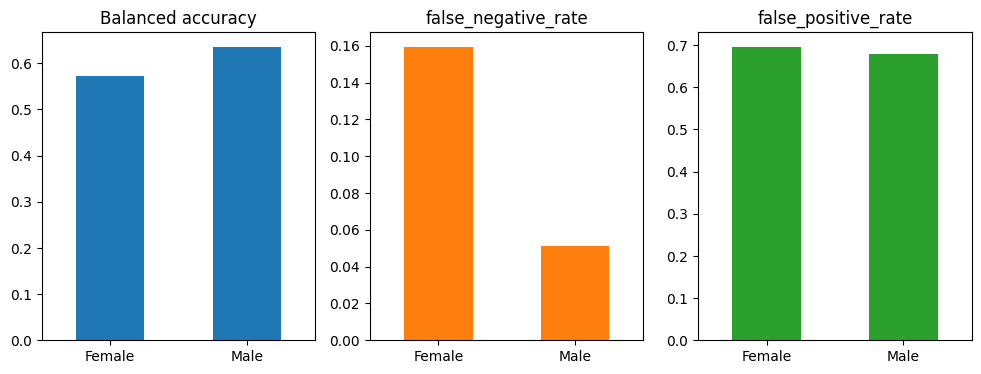

In [77]:
metricframe_ad.by_group[['Balanced accuracy', 'false_negative_rate', 'false_positive_rate']].plot.bar(
    subplots=True, layout=[1, 3], figsize=[12, 4], legend=None, rot=0
)

# Comparison

In [78]:
titles = ['Unmitigated', 'GridSearch', 'Threshold Optimizer', 'Exponentiated Gradient', 'Prejudice Remover', 'Adversial Debiasing']
metricframes = [metricframe_baseline, metricframe_grids, metricframe_thrOpt, metricframe_exp, metricframe_pr, metricframe_ad]
fairlearn_metrics = [fairlearn_baseline_metrics, fairlearn_grids_metrics, fairlearn_thrOpt_metrics, fairlearn_exp_metrics, fairlearn_pr_metrics, fairlearn_ad_metrics]

In [79]:
for i in range(len(titles)):
    print(titles[i])
    display(metricframes[i].by_group)

Unmitigated


,Balanced accuracy,Selection Rate,precision (calibration),recall (equal opportunity),false_positive_rate,false_negative_rate
Female,0.525362,0.573913,0.621212,0.594203,0.543478,0.405797
Male,0.643442,0.706383,0.825301,0.778409,0.491525,0.221591


GridSearch


,Balanced accuracy,Selection Rate,precision (calibration),recall (equal opportunity),false_positive_rate,false_negative_rate
Female,0.565217,0.643478,0.648649,0.695652,0.565217,0.304348
Male,0.629334,0.719149,0.816568,0.784091,0.525424,0.215909


Threshold Optimizer


,Balanced accuracy,Selection Rate,precision (calibration),recall (equal opportunity),false_positive_rate,false_negative_rate
Female,0.554348,0.652174,0.640000,0.695652,0.586957,0.304348
Male,0.643442,0.706383,0.825301,0.778409,0.491525,0.221591


Exponentiated Gradient


,Balanced accuracy,Selection Rate,precision (calibration),recall (equal opportunity),false_positive_rate,false_negative_rate
Female,0.525362,0.573913,0.621212,0.594203,0.543478,0.405797
Male,0.643442,0.706383,0.825301,0.778409,0.491525,0.221591


Prejudice Remover


,Balanced accuracy,Selection Rate,precision (calibration),recall (equal opportunity),false_positive_rate,false_negative_rate
Female,0.597826,0.660870,0.671053,0.739130,0.543478,0.260870
Male,0.646668,0.846809,0.814070,0.920455,0.627119,0.079545


Adversial Debiasing


,Balanced accuracy,Selection Rate,precision (calibration),recall (equal opportunity),false_positive_rate,false_negative_rate
Female,0.572464,0.782609,0.644444,0.840580,0.695652,0.159420
Male,0.635449,0.880851,0.806763,0.948864,0.677966,0.051136


In [80]:
fairness_metrics

,Unmitigated,GridSearch,Threshold Optimizer,Exponentiated Gradient,Prejudice Remover,Adversial Debiasing
Balanced Accuracy,0.606122,0.608163,0.610884,0.606122,0.639456,0.616327
Equalize Odds Difference,0.184206,0.088439,0.095431,0.184206,0.181324,0.108284
Selection Rate,0.662857,0.694286,0.688571,0.662857,0.785714,0.848571
Demographic Parity Difference,0.132470,0.132470,0.132470,0.132470,0.132470,0.132470


- The Balanced Accuracy improves slightly with GridSearch, Threshold Optimizer, and Adversarial Debiasing, with the highest improvement seen with Prejudice Remover (0.639456).
- GridSearch and Threshold Optimizer significantly reduce the Equalize Odds Difference, indicating improved fairness. Adversarial Debiasing also reduces this difference, but Exponentiated Gradient and Prejudice Remover show minimal change.
- Selection Rate increases with all methods, especially with Prejudice Remover and Adversarial Debiasing, indicating a higher proportion of positive predictions.
- The Demographic Parity Difference remains constant across all methods, suggesting that these techniques did not address this particular aspect of bias. This could indicate that either the metric is not impacted by these methods or that additional specific interventions are needed to address demographic parity.
